# Hypotesis 7: Are longer reviews more helpful?

In [1]:
import pymongo
import pandas as pd
import numpy as np
from seaborn import heatmap
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
import scipy.stats

In [2]:
# Connect to MongoDB and select the database 
mongo = pymongo.MongoClient()
mongo_db = mongo.project
# Load the reviews from the reviews collection 
data = pd.DataFrame(list(mongo_db.reviews.find({}, {'_id': False})))
#Close the connection
mongo.close() 
print(data.shape)

(300639, 11)


### Feature engineering
##### Add the columns "review_length" and "helpfulness_ratio"

In [3]:
# Calculate the length of each review and store it in a new column
data['review_length'] = data['review_detail'].apply(lambda x: len(str(x)))

# Calculate the helpfulness ratio for each review
data['helpfulness_ratio'] = data['helpful_upvotes'] / data['helpful_total']

In [4]:
data.head()

,movie,rating,genre,review_date,review_detail,review_id,review_summary,reviewer,spoiler_tag,helpful_upvotes,helpful_total,review_length,helpfulness_ratio
0,Satanic (2016),2,-,31 March 2019,"Seriously, don't waste yout time, this is a pr...",rw4754736,Mind numbing trash,axh-35735,0,1,3,180,0.333333
1,Satanic (2016),2,-,8 August 2018,Dropped out 20 mins in... characters were tota...,rw4274422,To lame to finish,skyking-14,0,1,4,407,0.250000
2,Satanic (2016),6,-,24 September 2016,Seeing the ratings on IMDb I wondered why the ...,rw3550183,Not a bad movie and a bit different,mjsreg,0,26,46,678,0.565217
3,Satanic (2016),2,-,30 October 2016,"I only did that because 1 is the lowest point,...",rw3571658,I gave it 2 stars!,gothic-fiction,0,9,18,1134,0.500000
4,Satanic Meat Cleaver Massacre (2017),1,-,2 August 2017,SATANIC MEAT CLEAVER MASSACRE is a dreadful in...,rw3770545,The title's a misnomer,Leofwine_draca,1,8,9,416,0.888889


### Analysis and visualization
#### Boxplot 

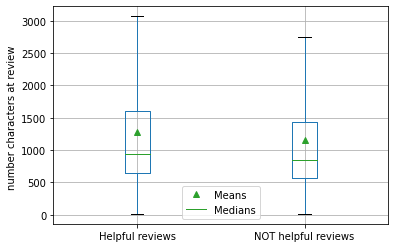

In [5]:
# Filter the DataFrame for helpful and NOT helpful reviews 
# The reviews with a helpfulness_ratio > 0.5 are considered helpful, otherwise they aren't
threshold = 0.5
helpful_reviews = data[data['helpfulness_ratio'] >= threshold]
NOT_helpful_reviews = data[data['helpfulness_ratio'] < threshold]

# Access the word_counts column for helpful reviews
helpful_length = helpful_reviews['review_length']
# Access the word_counts column for NOT helpful reviews
NOT_helpful_length = NOT_helpful_reviews['review_length'] 

length_at_review_boxplot = pd.DataFrame(data={
    'Helpful reviews': helpful_length ,
    'NOT helpful reviews': NOT_helpful_length 
}).boxplot(showfliers=False, showmeans=True, return_type='dict')
plt.legend([length_at_review_boxplot['means'][0], length_at_review_boxplot['medians'][0]], ['Means', 'Medians'])
plt.ylabel('number characters at review ');

We can see from the boxplot that helpful reviews are slighly longer than the not helpful ones.

Let's test futher the association between the two variables.

In [7]:
# is the data normally distributed ?

# Perform Shapiro-Wilk test
statistic, p_value = shapiro(data['review_length'])

# Print the test statistic and p-value
print('H0: The data is normally distributed')
print("Shapiro-Wilk test statistic:", statistic)
print("p-value:", p_value)
if p_value > 0.05:
    print('\nDo not reject the null hypothesis.')
else:
    print('\nReject the null hypothesis. The data is not normally distributed')

H0: The data is normally distributed
Shapiro-Wilk test statistic: 0.8049801588058472
p-value: 0.0

Reject the null hypothesis. The data is not normally distributed


/home/ds/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


As we have seen from the previous test, the data is not normally distributed so we have to use non parametric statistical tests to see if there is a relation between the two variables.

### MANN-WHITNEY U TEST

The test is expected to reject the null hypothesis, i.e., to conclude that the distribution underlying helpful_length is stochastically greater than the distribution underlying NOT_helpful_length, i.e., F(u) < G(u) for all u (if F is the cumulative distribution of helpful_length and G is the cumulative distribution of NOT_helpful_length)

In [8]:
mann_whitney_u_stat, p_value = scipy.stats.mannwhitneyu(helpful_length, NOT_helpful_length, alternative='greater')

# Print the test result
null_hypothesis_stat = helpful_length.size * NOT_helpful_length.size * 0.5
print(f'Mann–Whitney U test statistic under the null hypothesis: {null_hypothesis_stat:.3f}.')
print(f'Computed Mann–Whitney U test statistic: {mann_whitney_u_stat:.3f}, p-value: {p_value:.3f}.')

if p_value > 0.05:
    print('\nDo not reject the null hypothesis.')
else:
    print('\nReject the null hypothesis.')

Mann–Whitney U test statistic under the null hypothesis: 8683371312.000.
Computed Mann–Whitney U test statistic: 9408431507.500, p-value: 0.000.

Reject the null hypothesis.


### Effect size : Cohen's d.

In order to be sure on the relation between the two variables we can use the Cohen's d.

In [9]:
# Compute Cohen's d
mean_diff = np.mean(helpful_length) - np.mean(NOT_helpful_length)
pooled_std = np.sqrt((np.std(helpful_length)**2 + np.std(NOT_helpful_length)**2) / 2)
cohens_d = mean_diff / pooled_std

# Print the computed Cohen's d
print("Cohen's d:", cohens_d)

Cohen's d: 0.11438468906785494


A Cohen's d of 0.114 indicates that there is a small difference between the means of the compared groups. The positive sign suggests that the mean of one group is slightly higher than the mean of the other group. 
In conclusion, it can be said that there is a difference between the two groups and that the mean related to the helpful reviews, even if slightly, is higher than the mean related to the NOT helpful reviews.